In [1]:
!pip install imutils

In [2]:
# Import Libraries

# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

# Model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# Configuration
class CFG:
    batch_size = 64
    img_height = 64
    img_width = 64
    epochs = 15
    num_classes = 29
    img_channels = 3
    
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
# Labels
TRAIN_PATH = r"C:\ASL\asl_alphabet_train\asl_alphabet_train"
labels = []
alphabet = list(string.ascii_uppercase)
labels.extend(alphabet)
labels.extend(["del", "nothing", "space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [5]:
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

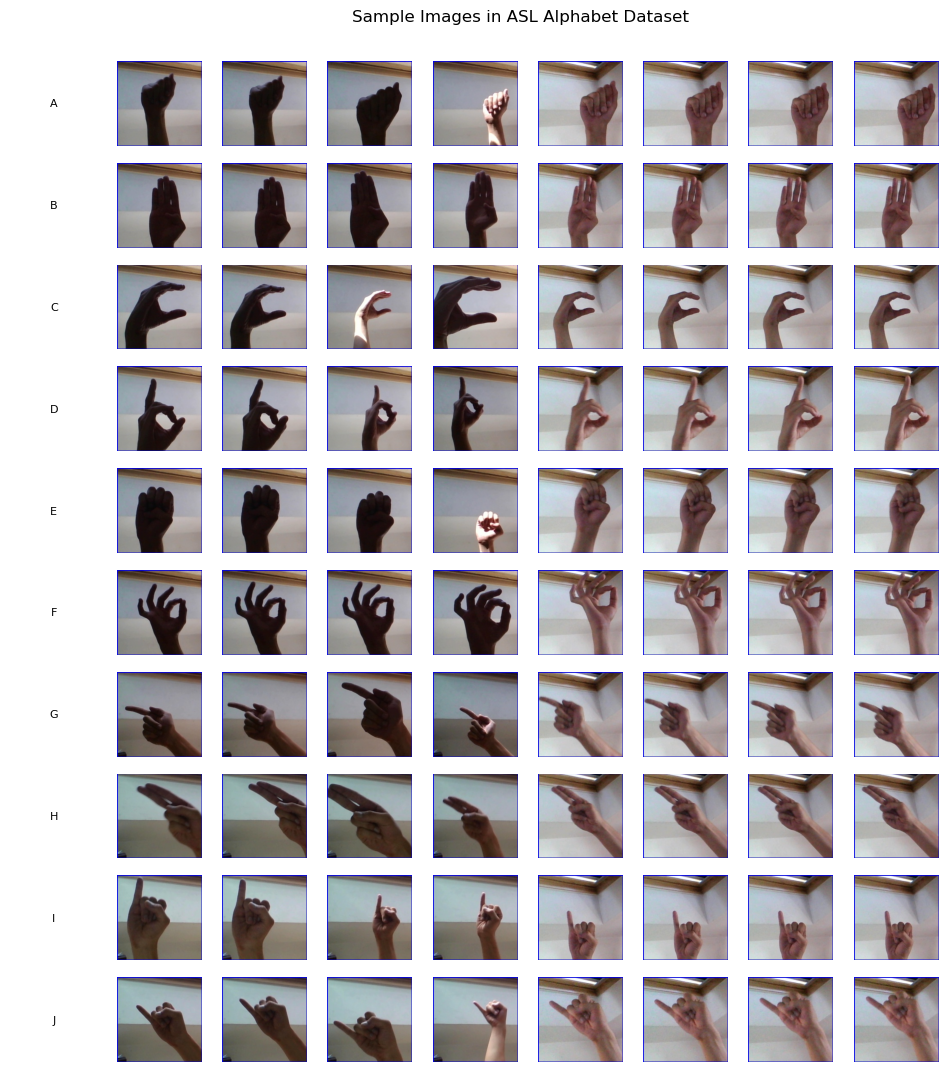

In [6]:
sample_images(labels[:10])

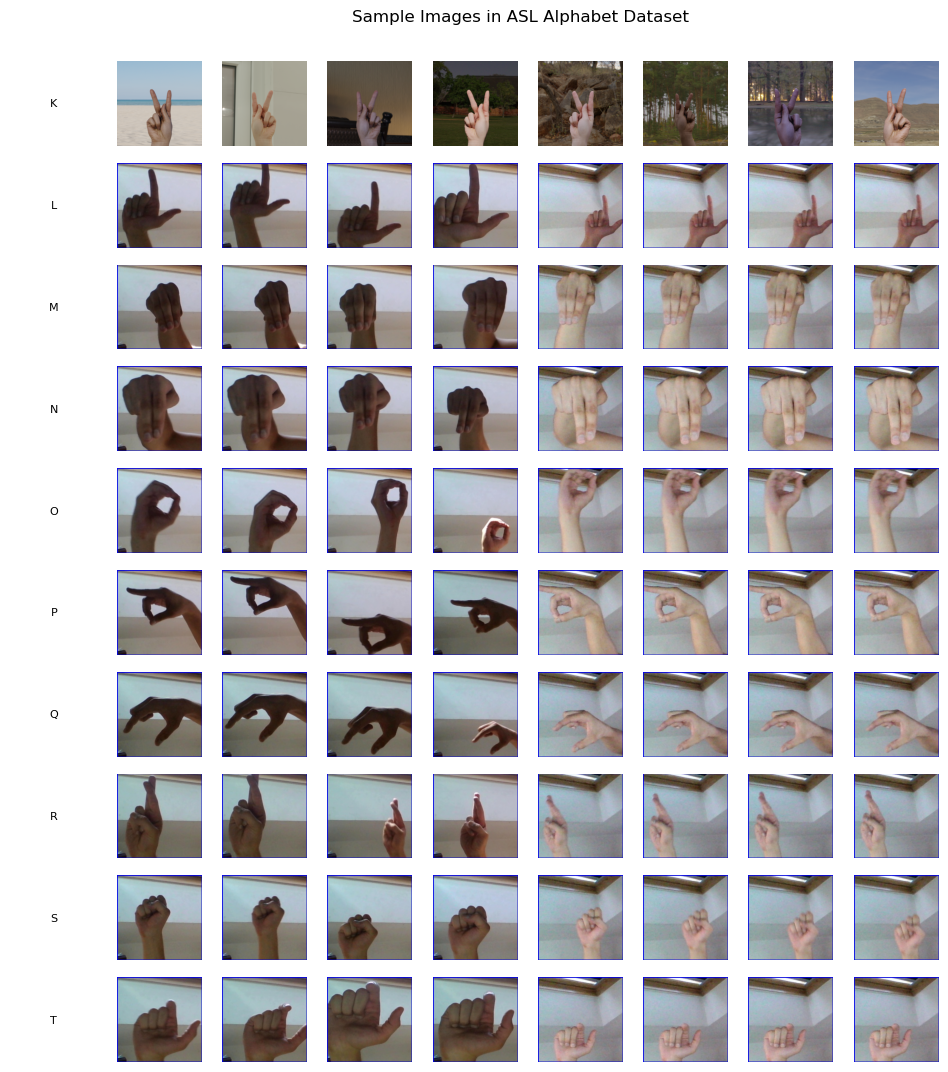

In [7]:
sample_images(labels[10:20])

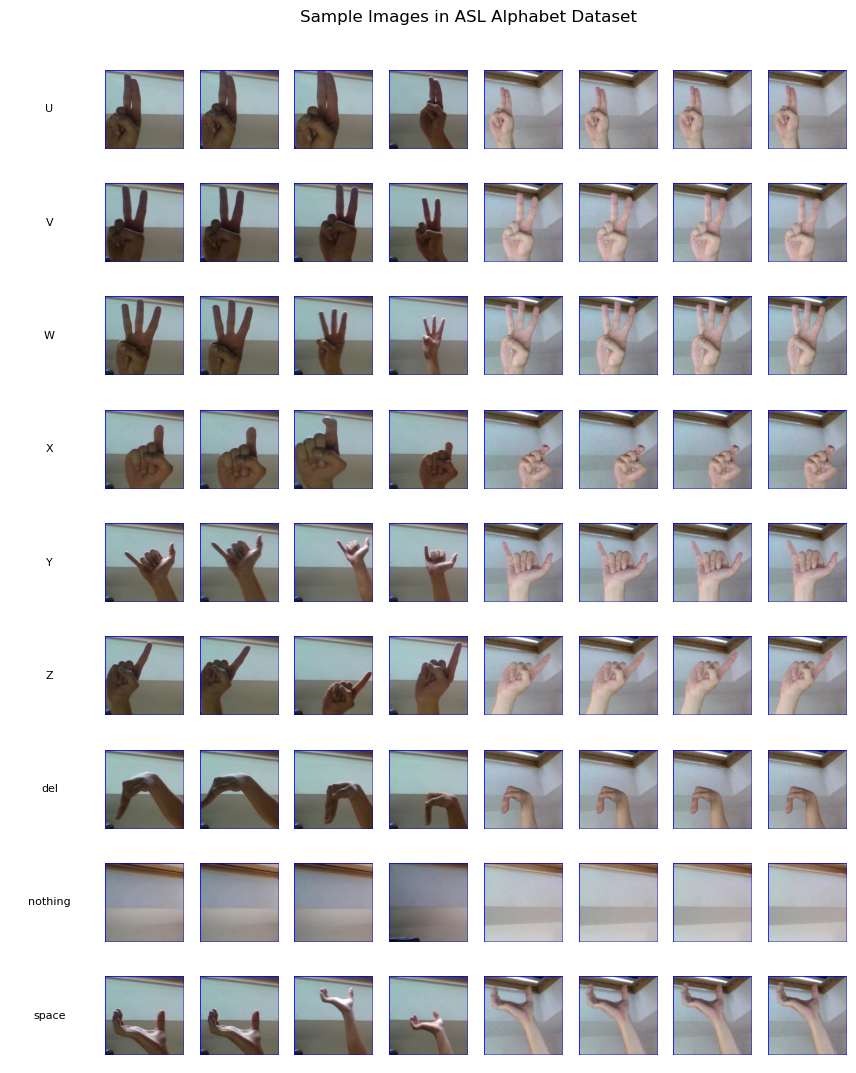

In [8]:
sample_images(labels[20:])

In [9]:
# Create Metadata
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

,image_path,label
0,C:\ASL\asl_alphabet_train\asl_alphabet_train\A...,A
1,C:\ASL\asl_alphabet_train\asl_alphabet_train\A...,A
2,C:\ASL\asl_alphabet_train\asl_alphabet_train\A...,A
3,C:\ASL\asl_alphabet_train\asl_alphabet_train\A...,A
4,C:\ASL\asl_alphabet_train\asl_alphabet_train\A...,A
...,...,...
85241,C:\ASL\asl_alphabet_train\asl_alphabet_train\s...,space
85242,C:\ASL\asl_alphabet_train\asl_alphabet_train\s...,space
85243,C:\ASL\asl_alphabet_train\asl_alphabet_train\s...,space
85244,C:\ASL\asl_alphabet_train\asl_alphabet_train\s...,space


In [10]:
# Split Dataset to Train 0.7, Val 0.15, and Test 0.15
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"], 
    test_size=0.15, 
    random_state=2023, 
    shuffle=True, 
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

display(data_train)
display(data_val)
display(data_test)

,image_path,label
35535,C:\ASL\asl_alphabet_train\asl_alphabet_train\M...,M
66379,C:\ASL\asl_alphabet_train\asl_alphabet_train\W...,W
79575,C:\ASL\asl_alphabet_train\asl_alphabet_train\n...,nothing
77540,C:\ASL\asl_alphabet_train\asl_alphabet_train\d...,del
79080,C:\ASL\asl_alphabet_train\asl_alphabet_train\d...,del
...,...,...
17599,C:\ASL\asl_alphabet_train\asl_alphabet_train\F...,F
44198,C:\ASL\asl_alphabet_train\asl_alphabet_train\P...,P
28487,C:\ASL\asl_alphabet_train\asl_alphabet_train\J...,J
59052,C:\ASL\asl_alphabet_train\asl_alphabet_train\U...,U


,image_path,label
54552,C:\ASL\asl_alphabet_train\asl_alphabet_train\S...,S
36166,C:\ASL\asl_alphabet_train\asl_alphabet_train\M...,M
84666,C:\ASL\asl_alphabet_train\asl_alphabet_train\s...,space
36294,C:\ASL\asl_alphabet_train\asl_alphabet_train\M...,M
25070,C:\ASL\asl_alphabet_train\asl_alphabet_train\I...,I
...,...,...
3055,C:\ASL\asl_alphabet_train\asl_alphabet_train\B...,B
13913,C:\ASL\asl_alphabet_train\asl_alphabet_train\E...,E
33341,C:\ASL\asl_alphabet_train\asl_alphabet_train\L...,L
83080,C:\ASL\asl_alphabet_train\asl_alphabet_train\s...,space


,image_path,label
78858,C:\ASL\asl_alphabet_train\asl_alphabet_train\d...,del
3150,C:\ASL\asl_alphabet_train\asl_alphabet_train\B...,B
46738,C:\ASL\asl_alphabet_train\asl_alphabet_train\Q...,Q
51552,C:\ASL\asl_alphabet_train\asl_alphabet_train\R...,R
36364,C:\ASL\asl_alphabet_train\asl_alphabet_train\M...,M
...,...,...
83962,C:\ASL\asl_alphabet_train\asl_alphabet_train\s...,space
52650,C:\ASL\asl_alphabet_train\asl_alphabet_train\S...,S
44049,C:\ASL\asl_alphabet_train\asl_alphabet_train\P...,P
15395,C:\ASL\asl_alphabet_train\asl_alphabet_train\F...,F


In [11]:
# Data Augmentation (Just Rescale)
def data_augmentation():
    datagen = ImageDataGenerator(rescale=1/255.,)
    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )
    
    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

In [12]:
seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()

Found 56932 validated image filenames belonging to 29 classes.
Found 15527 validated image filenames belonging to 29 classes.
Found 12787 validated image filenames belonging to 29 classes.


In [13]:
# Load VGG16 model and modify for ASL recognition
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
display(tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

None

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


None

In [14]:
# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('asl_checkpoint.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [15]:
# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/10
889/889 [==============================] - 1133s 1s/step - loss: 1.0560 - accuracy: 0.6656 - val_loss: 0.2360 - val_accuracy: 0.9277
Epoch 2/10
889/889 [==============================] - 423s 475ms/step - loss: 0.3766 - accuracy: 0.8711 - val_loss: 0.1151 - val_accuracy: 0.9684
Epoch 3/10
889/889 [==============================] - 918s 1s/step - loss: 0.2800 - accuracy: 0.9056 - val_loss: 0.0920 - val_accuracy: 0.9734
Epoch 4/10
889/889 [==============================] - 768s 864ms/step - loss: 0.2311 - accuracy: 0.9211 - val_loss: 0.0656 - val_accuracy: 0.9815
Epoch 5/10
889/889 [==============================] - 632s 711ms/step - loss: 0.2096 - accuracy: 0.9289 - val_loss: 0.0568 - val_accuracy: 0.9851
Epoch 6/10
889/889 [==============================] - 955s 1s/step - loss: 0.1822 - accuracy: 0.9373 - val_loss: 0.0602 - val_accuracy: 0.9795
Epoch 7/10
889/889 [==============================] - 411s 462ms/step - loss: 0.1716 - accuracy: 0.9414 - val_loss: 0.0412 - val_acc

In [16]:
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", scores[1]*100))

12787/12787 [==============================] - 255s 20ms/step - loss: 0.0342 - accuracy: 0.9907
Evaluate Test Accuracy: 99.07%


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [18]:
model.save("asl.h5")

In [19]:
# Confusion Matrix
fine_tuned_model = load_model(r"asl.h5")
predictions = fine_tuned_model.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=29)

12787/12787 [==============================] - 252s 20ms/step


In [20]:
#Load and Test the model
model = tf.keras.models.load_model(r"asl.h5")

In [21]:
image_path=r"C:\ASL\asl_alphabet_test\asl_alphabet_test\W\W_test.jpg"
img = cv2.imread(image_path)
img= cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(64,64))

# Preprocess the image 
img= tf.keras.applications.mobilenet_v2.preprocess_input(img)

# Make predictions on the image 
predictions = model.predict(np.array([img]))

# Get the predicted class label
predicted_class = labels [np.argmax (predictions)]
print(f"The predicted class is {predicted_class}")

1/1 [==============================] - 0s 149ms/step
The predicted class is W


In [22]:
image_path=r"C:\ASL\asl_alphabet_test\asl_alphabet_test\nothing\nothing_test.jpg"
img = cv2.imread(image_path)
img= cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(64,64))

# Preprocess the image 
img= tf.keras.applications.mobilenet_v2.preprocess_input(img)

# Make predictions on the image 
predictions = model.predict(np.array([img]))

# Get the predicted class label
predicted_class = labels [np.argmax (predictions)]
print(f"The predicted class is {predicted_class}")

1/1 [==============================] - 0s 33ms/step
The predicted class is nothing


In [23]:
image_path=r"C:\ASL\asl_alphabet_test\asl_alphabet_test\U\U_test.jpg"
img = cv2.imread(image_path)
img= cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(64,64))

# Preprocess the image 
img= tf.keras.applications.mobilenet_v2.preprocess_input(img)

# Make predictions on the image 
predictions = model.predict(np.array([img]))

# Get the predicted class label
predicted_class = labels [np.argmax (predictions)]
print(f"The predicted class is {predicted_class}")

1/1 [==============================] - 0s 32ms/step
The predicted class is U
